Name: 

# Advanced Machine Learning - Practicum 05 - Shallow Network

**Topics covered**: Implement the back propagation and prediction algorithms for a three layered feedforward neural network.

**Deliverables**:
- Complete the tasks as detailed in this document.
- You are to implement the algorithms from scratch, numpy and scipy packages are allowed. 

**Objectives**:  
This tutorial will help you get familiarized with feedforward neural network, its prediction and back propagation algorithms. The **Vectorization** method is encouraged to use.
- How to construct a three layered fully connected neural network.
- How to implement learning alogorithm - back propagation algorithm.
- How to apply the learnt model for binary-classification problem.

---
Import needed packages

In [2]:
import numpy as np
import scipy
from scipy.special import expit       # sigmoid
import matplotlib.pyplot as plt       # plot the learning curve
import copy

## 1. Structure of the Network

The feedforward neural network to be constructed consists of three layers: input, hidden and output layer. <br>

- Input layer:  the number of neurons is determined by the number of features. <br>
- Hidden layer: the number of neurons is specified by ther user. <br>
- Output layer: one neuron for only binary-classifiation.

## 2. Training data set - XOR

In [3]:
# input, truth table of XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])
print(X.shape, Y.shape)

(4, 2) (4, 1)


## 3. Initialize Parameters of the model

Implement function `ini_parameters` that takes in number of neurons at input layer and number of neurons at hidden layer, and return a parameter list. The list has 4 elements: <br>
- weights connecting input layer and hidden layer, an array with shape (number_inputs, number_hidden) <br>
- bias of hidden layer, an array with shape (1, number_hidden) <br>
- weights connecting hidden layer and output layer, an array with shape (number_hidden, 1) <br>
- bias of output layer, an array with shape (1,1)

Note: use `np.random.default_rng(12345)` to initialize a random generator, we'll use those initial values generated by this generator to valide your code step by step. 

In [4]:
def ini_parameters(number_inputs, number_hidden):
    
    para = []
    
    # random generator using a fixed seed
    rng = np.random.default_rng(12345)
    
    # Your code goes here
    w_input_hidden = rng.random((number_inputs, number_hidden))
    para.append(w_input_hidden)

    bias_hidden = rng.random((1, number_hidden))
    para.append(bias_hidden)

    w_hidden_output = rng.random((number_hidden, 1))
    para.append(w_hidden_output)

    # bias_output = rng.random((1, 1))
    bias_output = rng.random((1, 1))
    para.append(bias_output)

    return para

In [19]:
ini_parameters(2,3)

[array([[0.22733602, 0.31675834, 0.79736546],
        [0.67625467, 0.39110955, 0.33281393]]),
 array([[0.59830875, 0.18673419, 0.67275604]]),
 array([[0.94180287],
        [0.24824571],
        [0.94888115]]),
 array([[0.66723745]])]

## 4. Prediction

Your `prediction` function takes in the samples in `data` and parameters `para` and returns the output for both hidden layer and output layer, i.e. `yhat`. It also gives the user an option of activation function for hidden layer, `sigmoid` or `tanh`. 

In [39]:
def prediction(data, para, hidden_activation='tanh'):
    
    # Your code goes here   

    z1 = np.dot(data, para[0]) + para[1]
#     print(z1)

    if hidden_activation == 'tanh':
        a1 = np.tanh(z1)
    elif hidden_activation == 'sigmoid': 
        a1 = 1 / (1 + np.exp(-z1)) 
        
    z2 = np.tanh(z1)   
#     a2 = expit(z2)
    
    hidden_output = z2
    a2 = expit(a1.dot(para[2])+para[3])
    yhat = a2
    
    return hidden_output, yhat

Validate your function using the following code. The expected output is: 0.85.., 0.91.., 0.90.., 0.93..

In [40]:
hidden_output, yhat = prediction(X, ini_parameters(2, 3))
print(yhat)
print(hidden_output)

[[0.85501841]
 [0.91106751]
 [0.90677819]
 [0.93059649]]
[[0.53584502 0.18459359 0.58678988]
 [0.85502967 0.52109645 0.7639235 ]
 [0.67813052 0.46485941 0.89960063]
 [0.90549091 0.71365935 0.94710916]]


## 5. Loss function

We want to moniter the learning pocess by looking at the Accuracy/Error procduced by parameters at each iteration. A loss function should be defined. Implement the function `likelihood_loss` to calculate the negative log likelihood loss on the given data with a particlular choice of parameters. <br>
$$
loss=-\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}logyhat^{(i)}+(1-y^{(i)})log(1-yhat^{(i)})]
$$

In [41]:
def likelihood_loss(data, target, para):
    
    # Your code goes here
#     loss = 0
#     for i in range(len(yhat)):
#         loss += (target[i]*np.log(yhat[i]) + (1-target[i])*(np.log(1-yhat[i])))
#     loss = (-1/(len(yhat))) * loss
    hidden_output, yhat = prediction(data, para, hidden_activation='tanh')
    loss = - (1 / len(yhat)) * np.sum(np.multiply(target, np.log(yhat)) + np.multiply(1 - target, np.log(1 - yhat)))
    
    return loss

Validate your function using the following code. The expected output is: 1.19..

In [42]:
likelihood_loss(X,Y,ini_parameters(2, 3))

1.1974905066304478

## 5. Back Propagation

Briefly review the steps in the learning process, each iteration: <br>
- Take feedforward and get the ouput for each layers <br>
- Take back propagation <br>
    - Compute sensitivity for each neuron <br>
    - Compute gradient for each weight <br>
    - Update all parameters <br>
- Compute the loss on train and validation set respectively, and save the optimal parameters basing on smallest validation loss.

In [55]:
def back_propagation(train_data, train_target, validation_data, validation_target, hidden_neurons=3, alpha=0.5, hidden_activation='tanh', iteration=1000):
    
    # parameters:   train_data            featrue data for training the model 
    #               train_target          target for training
    #               validation_data       feature data for validation
    #               validation_target     target for validation
    #               hidden_neurons        number of neurons at hidden layer
    #               alpha                 learing rate as in gradient descent
    #               hidden_activation     either "tanh" or "sigmoid"
    #               iteration             maximal number of iteration
    # return:       lossHistory           2 lists, one is train loss, another is valiation loss
    #               the model             a list of updated parameters
    
    # Your code goes here
    opt_para = ini_parameters(train_data.shape[1], hidden_neurons)
    print(train_data.shape[1])
    print(hidden_neurons)
    aa = []
    bb = []
    LossHistory = [aa, bb]
    for _ in range(iteration):
#         opt_para = ini_parameters(train_data.shape[1], hidden_neurons)
        output_from_hidden, yhat = prediction(train_data, opt_para, hidden_activation) # np.tanh(np.dot(X, weight_hidden) + bias_hidden)    
        output_delta_list = -(train_target - yhat) * yhat * (1 - yhat)
        delta_hidden = np.dot(output_delta_list, opt_para[2].T) * (1 - np.square(output_from_hidden))
        opt_para[2] = opt_para[2] - alpha * (np.dot(output_from_hidden.T, output_delta_list) / 4)
#         opt_para[3] = opt_para[3] - alpha * (np.sum(output_delta_list) / 4)
        opt_para[3] = opt_para[3] - alpha * output_delta_list.mean()
        opt_para[0] = opt_para[0] - alpha * (np.dot(train_data.T, delta_hidden) / 4)
#         opt_para[1] = opt_para[1] - alpha * (np.sum(delta_hidden, axis = 0) / 4)
        opt_para[1] = opt_para[1] - alpha * delta_hidden.mean(axis=0)
    
        aa.append(likelihood_loss(train_data, train_target, opt_para))
        bb.append(likelihood_loss(validation_data, validation_target, opt_para))
    
    return LossHistory, opt_para;        

Validate your function using the following code. The expected output is: 0.12.., 0.88.., 0.88.., 0.15..

In [58]:
loss, parameters = back_propagation(X,Y,X,Y,3,0.5,"tanh")
_, yhat = prediction(X,parameters)
print(yhat)

2
3
[[0.12743758]
 [0.88900628]
 [0.88868061]
 [0.15958506]]


## 6. Plot Learning Curve

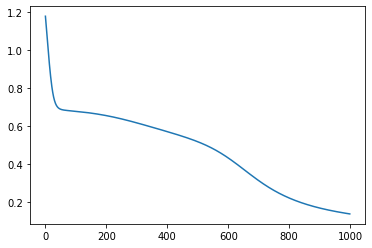

In [63]:
# Plot the learning curves for the returned loss on validation data.

#### Your code goes here
plt.plot(loss[0])
# plt.plot(loss[1])
plt.show()

## 7. Summary

XOR truth table is an inseparable dataset. Logistic regreesion failed in building a model from it. Multi-layered neural network is proposed to bulid a classfier from inspeparable dataset. Nowadays it is becoming the foundation of deep learning structure. <br>
If you have time, try explore your model by: <br>
- changing the hyper parameters and observe the result and learning curve, e.g. number of neurons at hidden layer etc.
- applying your model for other binary-classification problem.
